In [1]:
from matplotlib import pyplot as plt
import sys
import pandas as pd
import numpy as np
import math

sys.path.append('../../src')

from heat_load_calc.core import solar_shading

In [2]:
plt.style.use('seaborn-whitegrid')

# 無限に長い庇による天空日射の遮へい効果の計算

<div style="text-align: right;">佐藤エネルギーリサーチ（株）</div>

## はじめに

無限に長い庇について、天空日射に対する遮へい効果の計算法について述べる。

## 各部寸法

窓、庇共に無限に長いと仮定し、下図のような寸法が与えられるとする。

<img src="fig/solar_shading.png" width=20%>

<div style="text-align: center;">図 1　無限に長い庇の寸法</div>

## 形態係数の計算方法

窓、庇が無限に続くと仮定したため、2次元で扱えばよい。クロス・ストリング法を適用すると、窓から庇を見る形態係数は下式となる。

$$
\begin{eqnarray*}
\varphi &=& \frac{ ( AC + BD ) - ( AD + BC ) }{ 2 DC } \\
   &=& \frac{ ( ( y_1 + y_w ) + \sqrt{ y_1^2 + z^2 } )- ( y_1 + \sqrt{ ( y_1 + y_w )^2 + z^2  } ) }{ 2 y_w }
\end{eqnarray*}
$$

ここで、

$\varphi$：	窓から庇を見る形態係数 -

## 無限に長い庇があるときの窓の天空透過日射熱取得

無限に長い庇があるときの窓の天空透過日射熱取得は下式となる。

$$ Q_{GT,d} = A \cdot ( 1 - \varphi ) \cdot \tau_N \cdot c \cdot I_d $$

ここで、  
$Q_{GT,d}$：天空透過日射熱取得, W
$A$：窓面積, m<sup>2</sup>  
$\tau_N$：窓の垂直入射時透過率, -  
$c$：窓の拡散光に対する入射角特性  
$I_d$：窓に入射する天空日射, W/m<sup>2</sup>

## Example

### 天空日射に対する形態係数の計算関数

In [3]:
def get_f_ss_s(w_alpha, depth, d_h, d_e):
    sss = solar_shading.SolarShadingSimple(w_alpha=w_alpha, depth=depth, d_h=d_h, d_e=d_e)
    return sss.get_f_ss_s_j()

### 直達日射に対する形態係数の計算関数

In [4]:
def get_f_ss_d_j_ns(w_alpha, depth, d_h, d_e, h_sun, a_sun, sh, sw, ss):
    sss = solar_shading.SolarShadingSimple(w_alpha=w_alpha, depth=depth, d_h=d_h, d_e=d_e)
    w_beta = math.radians(90)
    wz = math.cos(w_beta)
    ww = math.sin(w_beta) * math.sin(w_alpha)
    ws = math.sin(w_beta) * math.cos(w_alpha)
    cos_theta = sh * wz + sw * ww + ss * ws
    
    a_shdw = sss.get_f_ss_d_j_ns(h_sun_n=h_sun, a_sun_n=a_sun)
    a_shdw = np.where(cos_theta < 0.0, 1.0, a_shdw)
    a_shdw = np.where(h_sun == 0.0, 1.0, a_shdw)
    return a_shdw

計算例  
- 方位角 0度
- 庇の深さ 1.0m
- 窓の高さ 2.0m
- 窓上端から庇の付け根までの長さ 0.2m

In [5]:
f_ss = get_f_ss_s(w_alpha=0.0, depth=1.0, d_h=2.0, d_e=0.2)

In [6]:
# 気象データ読み込み
d_weather = pd.read_csv('../../notebook/initializer/climateData_6.csv')
h_rad = np.radians(d_weather['太陽高度角[度]'].values)
a_rad = np.radians(d_weather['太陽方位角[度]'].values)
sh = np.sin(h_rad)
sw = np.cos(h_rad) * np.sin(a_rad)
ss = np.cos(h_rad) * np.cos(a_rad)

#### 南向き日影面積

In [7]:
south_face = get_f_ss_d_j_ns(w_alpha=math.radians(0.0), depth=1.0, d_h=2.0, d_e=0.2, h_sun=h_rad, a_sun=a_rad, sh=sh, sw=sw, ss=ss)

#### 東向き日影面積

In [8]:
east_face = get_f_ss_d_j_ns(w_alpha=math.radians(-90.0), depth=1.0, d_h=2.0, d_e=0.2, h_sun=h_rad, a_sun=a_rad, sh=sh, sw=sw, ss=ss)

#### 南東向き日影面積

In [9]:
se_face = get_f_ss_d_j_ns(w_alpha=math.radians(-45.0), depth=1.0, d_h=2.0, d_e=0.2, h_sun=h_rad, a_sun=a_rad, sh=sh, sw=sw, ss=ss)

#### ファイル出力

In [10]:
# 計算は1時始まりだが、時間ラベルが0時始まりなので１つずらす
dd_output = pd.DataFrame(index=pd.date_range(start='1/1/1989', periods=8760, freq='H'))
dd_output['h'] = np.roll(np.degrees(h_rad), 1)
dd_output['a'] = np.roll(np.degrees(a_rad), 1)
# 影の面積から日向の面積へ変換
dd_output['south'] = np.roll(1.0 - south_face, 1)
dd_output['east'] = np.roll(1.0 - east_face, 1)
dd_output['south-east'] = np.roll(1.0 - se_face, 1)
dd_output['sky_radiation'] = 0.5 - np.full(len(south_face), f_ss)
dd_output.to_csv('../../notebook/initializer/result.csv', encoding='cp932')

庇の長さを0.0mから3.0mまで0.1m刻みで振る

In [11]:
zs = [float(x) / 10.0 for x in range(0, 31)]

In [12]:
fai1 = [get_f_ss_s(w_alpha=0.0, depth=z, d_h=0.6, d_e=0.0) for z in zs]

In [13]:
fai2 = [get_f_ss_s(w_alpha=0.0, depth=z, d_h=1.2, d_e=0.0) for z in zs]

In [14]:
fai3 = [get_f_ss_s(w_alpha=0.0, depth=z, d_h=2.0, d_e=0.0) for z in zs]

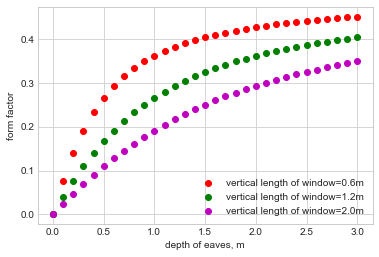

In [15]:
fig1 = plt.figure()
ax1 = fig1.subplots()

ax1.scatter(zs, fai1, c="r", label="vertical length of window=0.6m")
ax1.scatter(zs, fai2, c="g", label="vertical length of window=1.2m")
ax1.scatter(zs, fai3, c="m", label="vertical length of window=2.0m")

ax1.set_xlabel('depth of eaves, m')
ax1.set_ylabel('form factor')

plt.legend()
plt.show()